In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter('ignore')

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_squared_error, r2_score

# Data Load

In [2]:
df = pd.read_excel("./data/energy/dataset.xlsx")
print(df.shape)
df.head()

(168079, 28)


,No,Trial,ModelID,Feature,Command,Trajectory,CuttingSpeed,SpindleSpeed,CuttingDepth,Timestamp,...,Yload,Zload,S1load,Block,rValue,iValue,jValue,XDirection,YDirection,ZDirection
0,1,1,Profile1_G01_App,Profile1,G01,App,76.2,1500,1.5,2014-10-30T21:33:20.624Z,...,5,12,3,Z-1.5000,NaN,NaN,NaN,NaN,NaN,D
1,2,1,Profile1_G01_App,Profile1,G01,App,76.2,1500,1.5,2014-10-30T21:33:20.905Z,...,4,10,3,Z-1.5000,NaN,NaN,NaN,NaN,NaN,D
2,3,1,Profile1_G01_App,Profile1,G01,App,76.2,1500,1.5,2014-10-30T21:33:21.202Z,...,5,9,3,Z-1.5000,NaN,NaN,NaN,NaN,NaN,D
3,4,1,Profile1_G01_App,Profile1,G01,App,76.2,1500,1.5,2014-10-30T21:33:21.498Z,...,5,10,3,Z-1.5000,NaN,NaN,NaN,NaN,NaN,D
4,5,1,Profile1_G01_App,Profile1,G01,App,76.2,1500,1.5,2014-10-30T21:33:21.794Z,...,4,9,3,Z-1.5000,NaN,NaN,NaN,NaN,NaN,D


# EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168079 entries, 0 to 168078
Data columns (total 28 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   No               168079 non-null  int64  
 1   Trial            168079 non-null  int64  
 2   ModelID          168079 non-null  object 
 3   Feature          168079 non-null  object 
 4   Command          168079 non-null  object 
 5   Trajectory       168079 non-null  object 
 6   CuttingSpeed     168079 non-null  float64
 7   SpindleSpeed     168079 non-null  int64  
 8   CuttingDepth     168079 non-null  float64
 9   Timestamp        168079 non-null  object 
 10  Absolute Time    168079 non-null  int64  
 11  Power            168079 non-null  float64
 12  Path_feedrate    168079 non-null  int64  
 13  S1speed          168079 non-null  int64  
 14  Path_position_X  168079 non-null  float64
 15  Path_position_Y  168079 non-null  float64
 16  Path_position_Z  168079 non-null  floa

## Correlation
1 : 매우 강함  
0.7 ~ 0.9 : 강함  
0.4 ~ 0.7 : 상관관계가 있음  
0.2 ~ 0.4 : 약함  
0 ~ 0.1 : 매우 약함  

<AxesSubplot:>

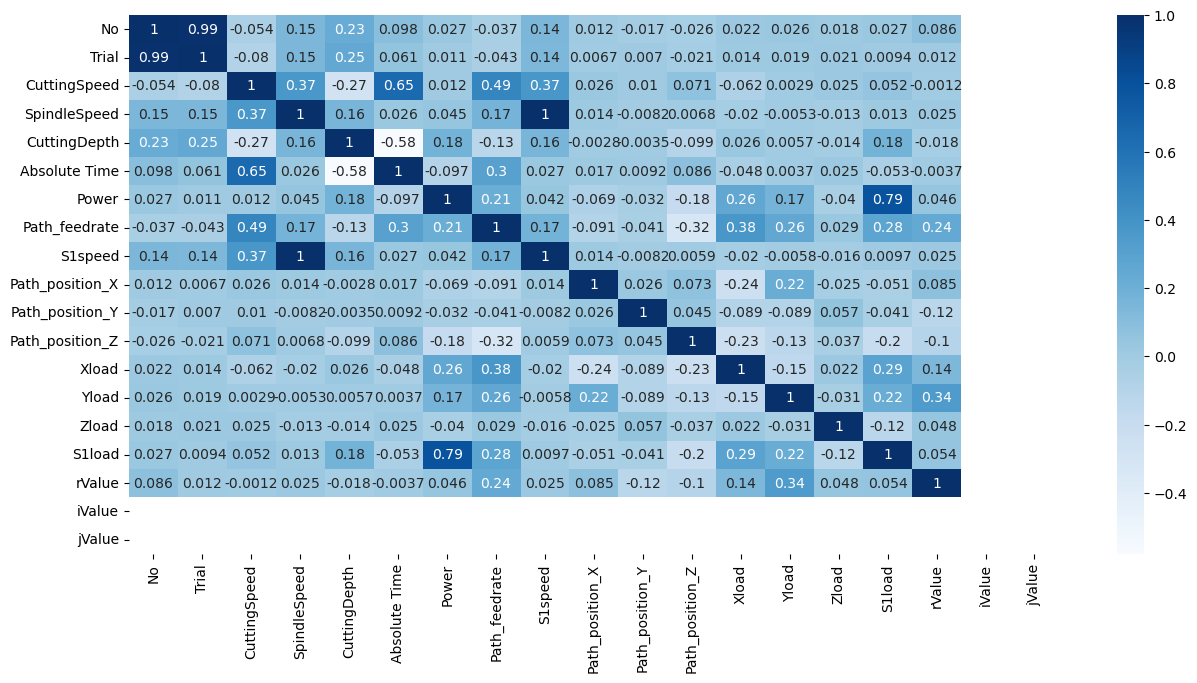

In [4]:
plt.figure(figsize=(15, 7))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap="Blues")

In [5]:
for i in range(len(df.columns)):
    print(f"{df.columns[i]} ({len(df.iloc[:, i].unique())}):\n{df.iloc[:, i].unique()}\n", "="*30)

No (168079):
[     1      2      3 ... 168077 168078 168079]
Trial (12):
[ 1  2  3  4  5  6  7  8  9 10 11 12]
ModelID (58):
['Profile1_G01_App' 'Profile1_G01_YFeed' 'Profile1_G01_XFeed'
 'Profile1_G02_CFeed' 'Profile1_G01_Ret' 'Slot1_G01_App' 'Slot1_G01_Back'
 'Slot1_G01_XFeed' 'Slot1_G01_YFeed' 'Slot1_G01_Ret' 'Slot1_G03_CFeed'
 'Slot2_G01_App' 'Slot2_G01_Feed' 'Slot2_G01_Back' 'Slot2_G01_Ret'
 'Slot3_G01_Feed' 'Slot3_G01_Back' 'Slot3_G01_Ret' 'Slot3_G01_App'
 'Pocket1_G01_App' 'Pocket1_G01_Feed' 'Pocket1_G01_Step' 'Pocket1_G01_Ret'
 'Pocket2_G01_App' 'Pocket2_G01_YFeed' 'Pocket2_G01_XFeed'
 'Pocket2_G01_Ret' 'Pocket3_G01_App' 'Pocket3_G01_YFeed'
 'Pocket3_G01_XFeed' 'Pocket3_G02_CFeed' 'Pocket3_G01_Ret'
 'Slot4_G01_Feed' 'Slot4_G01_Back' 'Slot4_G01_Ret' 'Slot4_G01_App'
 'Slot5_G01_App' 'Slot5_G01_Feed' 'Slot5_G01_Back' 'Slot5_G01_Ret'
 'Slot6_G01_Feed' 'Slot6_G01_App' 'Slot6_G01_Back' 'Slot6_G01_Ret'
 'Slot7_G01_App' 'Slot7_G03_CFeed' 'Slot7_G02_Back' 'Slot7_G02_CFeed'
 'Slot7_G03_B

# Data Preprocessing

In [6]:
# No 삭제
df.drop("No", axis=1, inplace=True)

In [7]:
# ModelID 는 Feature+Command+Trajectory의 조합 -> 의미가 중복되는 데이터 삭제
df.drop("ModelID", axis=1, inplace=True)

In [8]:
# 대부분의 값이 Null인 Column 삭제
df.drop(["rValue", "iValue", "jValue"], axis=1, inplace=True)

In [9]:
# Timestamp/Absolute Time 삭제
df.drop(["Timestamp", "Absolute Time"], axis=1, inplace=True)

## Object to Numeric / Categorical

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168079 entries, 0 to 168078
Data columns (total 21 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Trial            168079 non-null  int64  
 1   Feature          168079 non-null  object 
 2   Command          168079 non-null  object 
 3   Trajectory       168079 non-null  object 
 4   CuttingSpeed     168079 non-null  float64
 5   SpindleSpeed     168079 non-null  int64  
 6   CuttingDepth     168079 non-null  float64
 7   Power            168079 non-null  float64
 8   Path_feedrate    168079 non-null  int64  
 9   S1speed          168079 non-null  int64  
 10  Path_position_X  168079 non-null  float64
 11  Path_position_Y  168079 non-null  float64
 12  Path_position_Z  168079 non-null  float64
 13  Xload            168079 non-null  int64  
 14  Yload            168079 non-null  int64  
 15  Zload            168079 non-null  int64  
 16  S1load           168079 non-null  int6

In [11]:
object_cols = ["Feature", "Command", "Trajectory", "Block", "XDirection", "YDirection", "ZDirection"]
for col in object_cols:    
    le = preprocessing.LabelEncoder()
    le.fit(df[col])
    df[col] = le.transform(df[col])

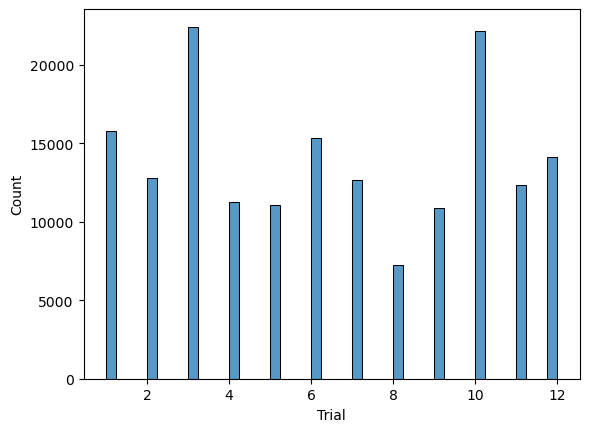

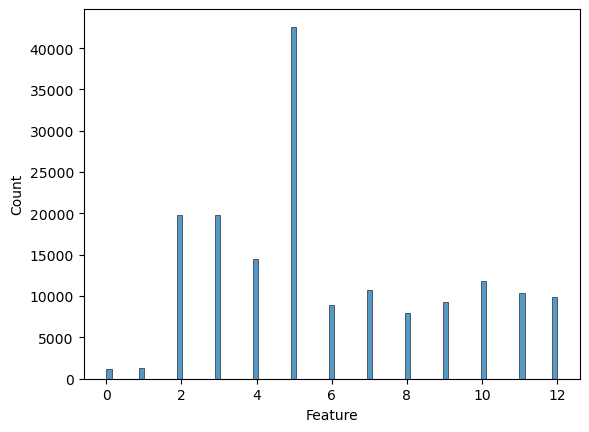

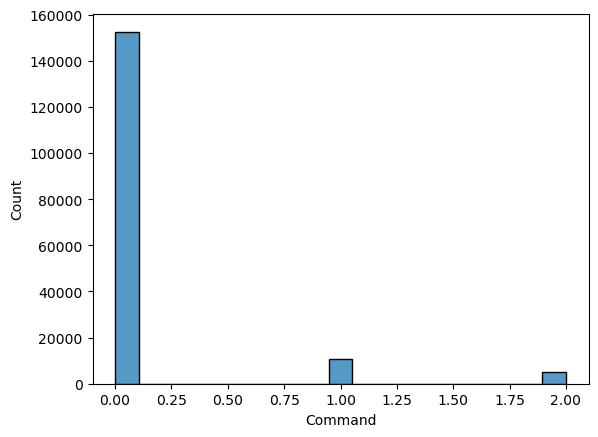

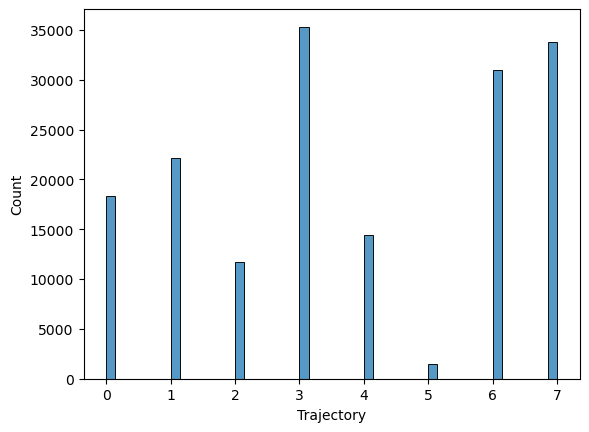

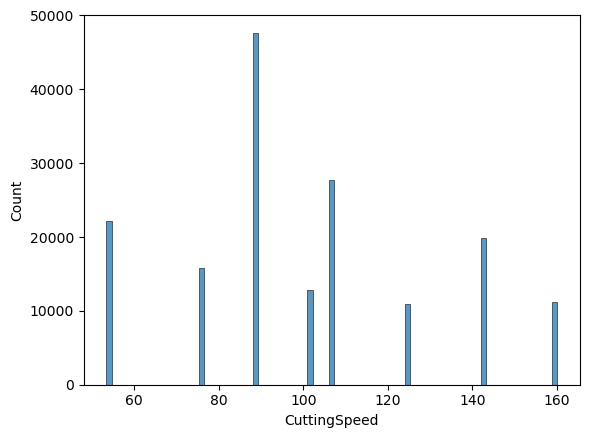

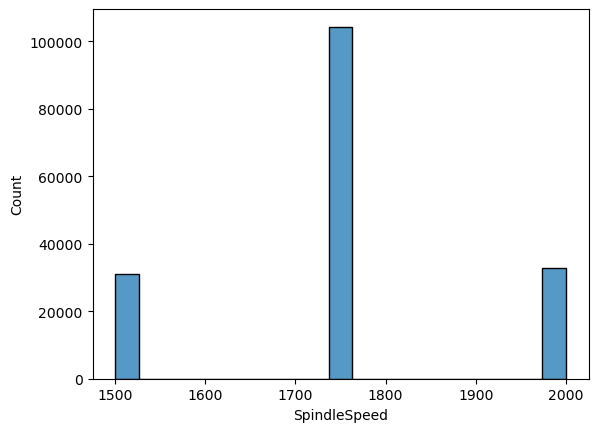

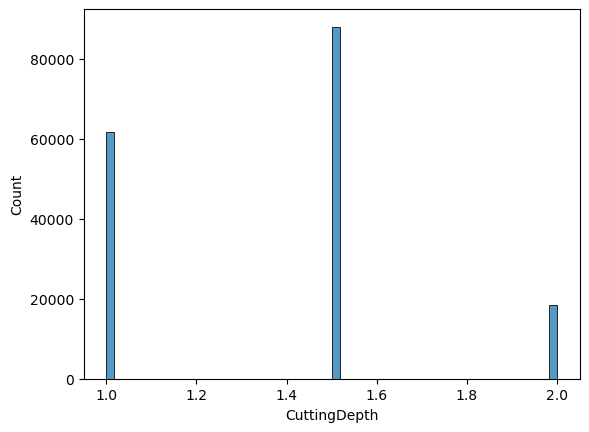

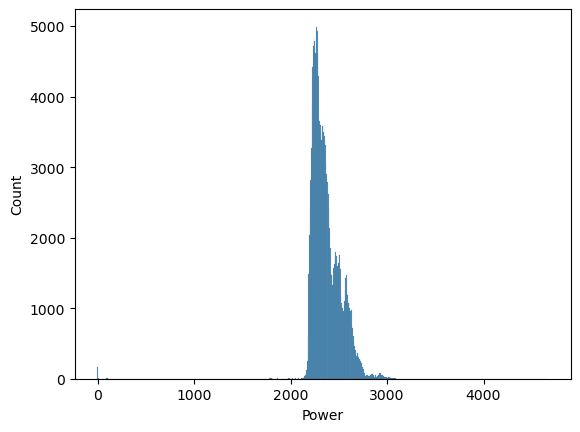

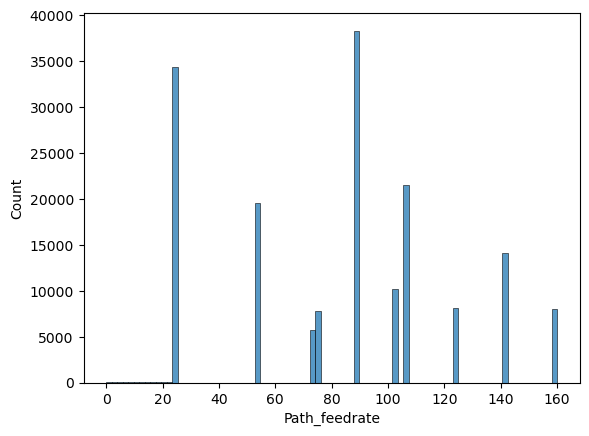

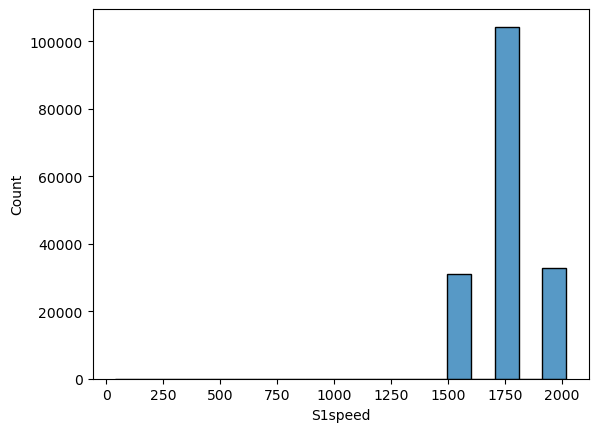

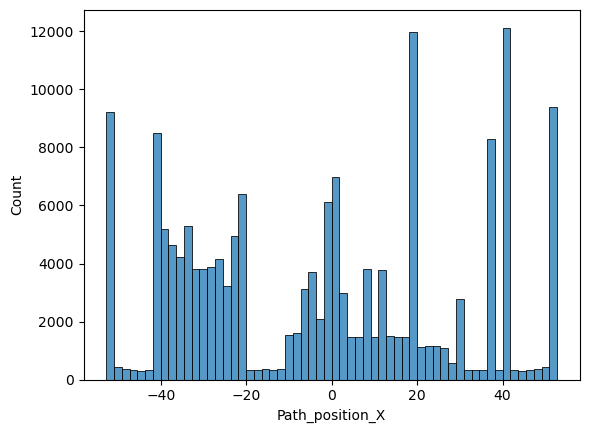

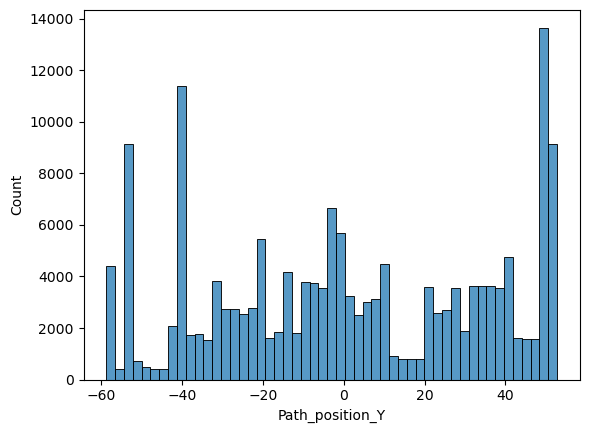

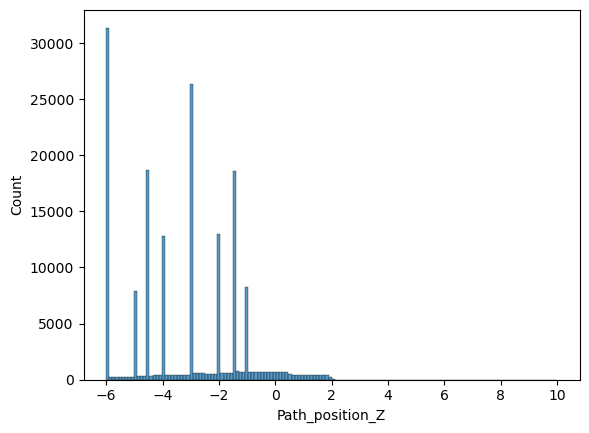

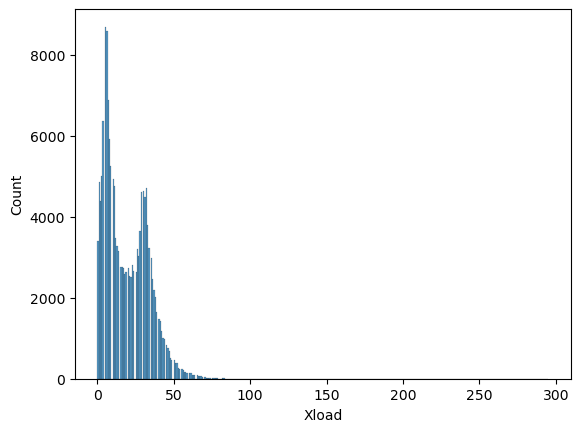

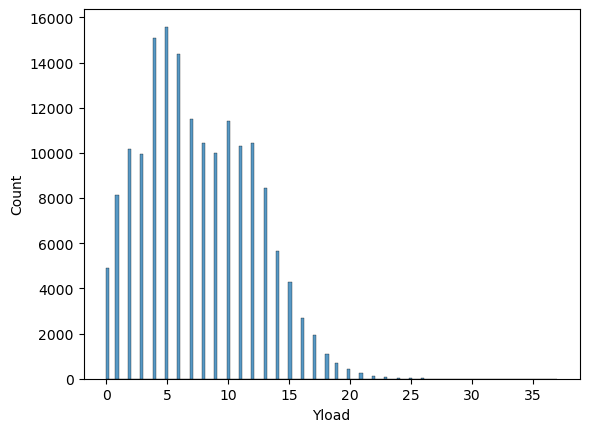

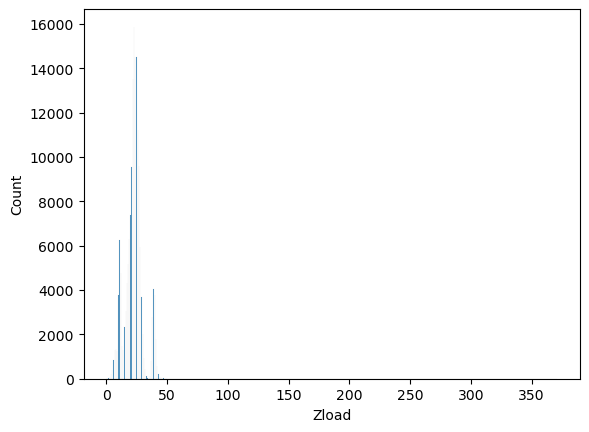

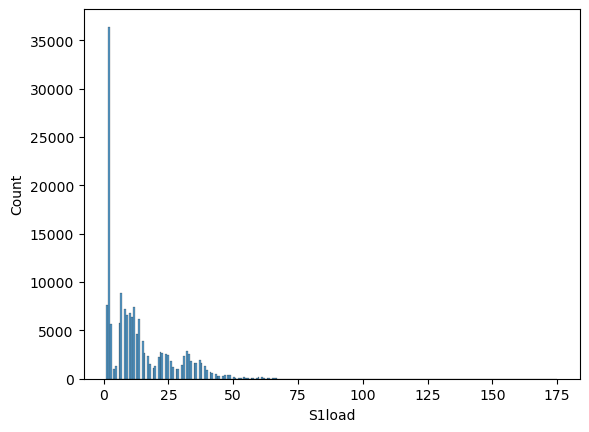

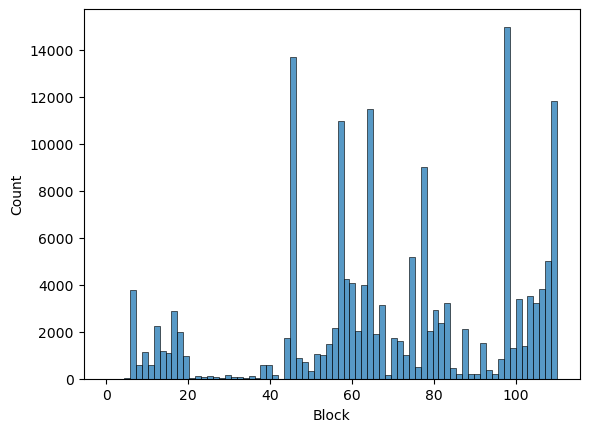

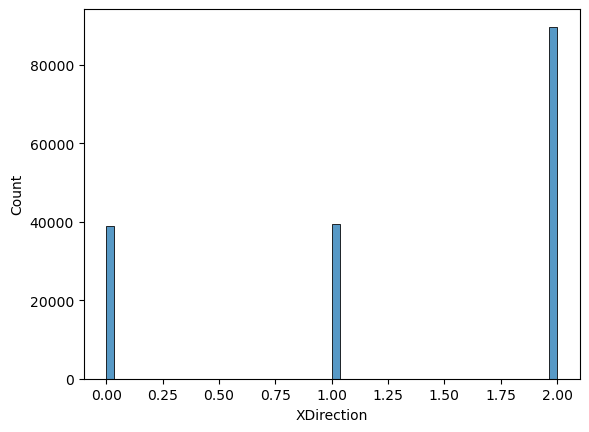

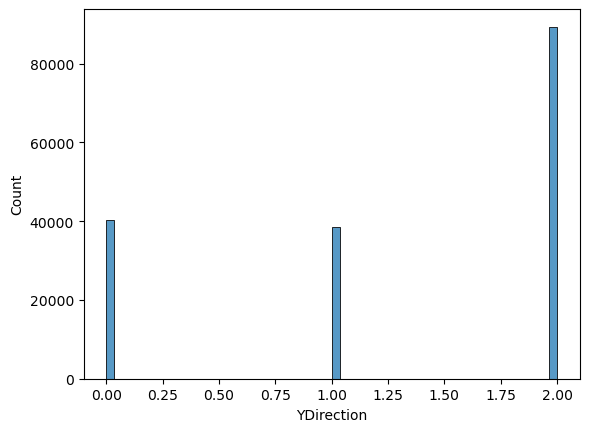

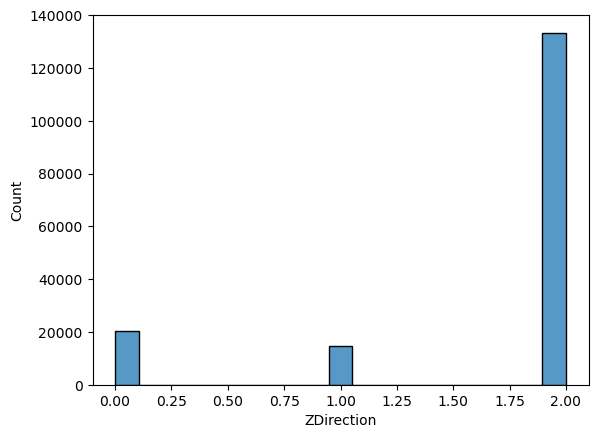

In [12]:
for i in range(len(df.columns)):
    sns.histplot(df.iloc[:, i])
    plt.show()

## Correlation
1 : 매우 강함  
0.7 ~ 0.9 : 강함  
0.4 ~ 0.7 : 상관관계가 있음  
0.2 ~ 0.4 : 약함  
0 ~ 0.1 : 매우 약함  

<AxesSubplot:>

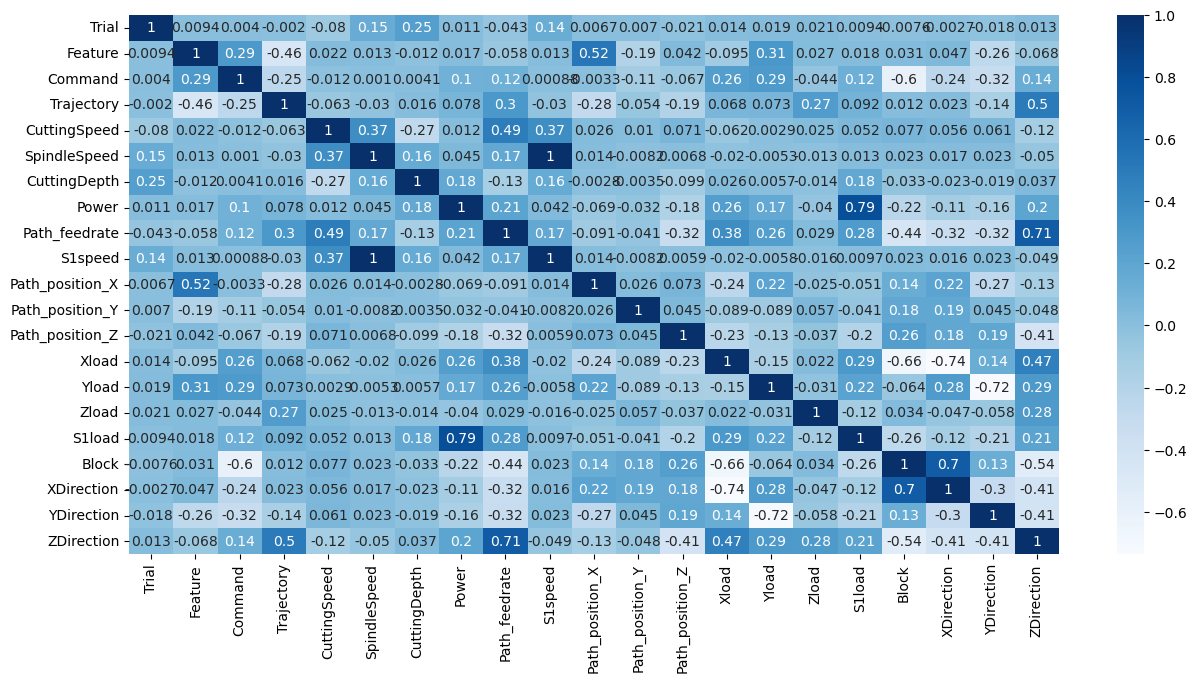

In [13]:
plt.figure(figsize=(15, 7))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap="Blues")

# Model

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(["Power"], axis=1), df["Power"], test_size=0.33, random_state=42)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(112612, 20) (55467, 20)
(112612,) (55467,)


In [15]:
X_train.head()

,Trial,Feature,Command,Trajectory,CuttingSpeed,SpindleSpeed,CuttingDepth,Path_feedrate,S1speed,Path_position_X,Path_position_Y,Path_position_Z,Xload,Yload,Zload,S1load,Block,XDirection,YDirection,ZDirection
134781,10,4,1,2,53.34,1750,1.5,53,1748,-22.8644,-27.3326,-3.00,19,14,28,22,8,1,0,2
14773,1,11,0,1,76.20,1500,1.5,76,1499,11.7718,-2.9718,-6.00,30,9,28,2,62,0,1,2
66294,5,7,0,4,88.90,1750,2.0,25,1748,19.5370,48.8000,-4.39,4,5,38,1,110,2,2,1
27661,2,12,1,1,101.60,2000,1.5,102,2000,6.4224,-26.0258,-1.50,28,8,25,2,7,0,1,2
3149,1,5,0,6,76.20,1500,1.5,74,1499,39.6200,-52.7690,-4.50,31,7,15,12,60,0,2,2


In [16]:
y_train.head()

134781    2467.200
14773     2213.184
66294     2260.544
27661     2237.568
3149      2348.544
Name: Power, dtype: float64

In [17]:
svr = LinearSVR()
svr.fit(X_train, y_train)
y_pred = svr.predict(X_test)

r2: 0.05624864105822436
mse: 25872.502941126422
rmse: 160.84931750283064


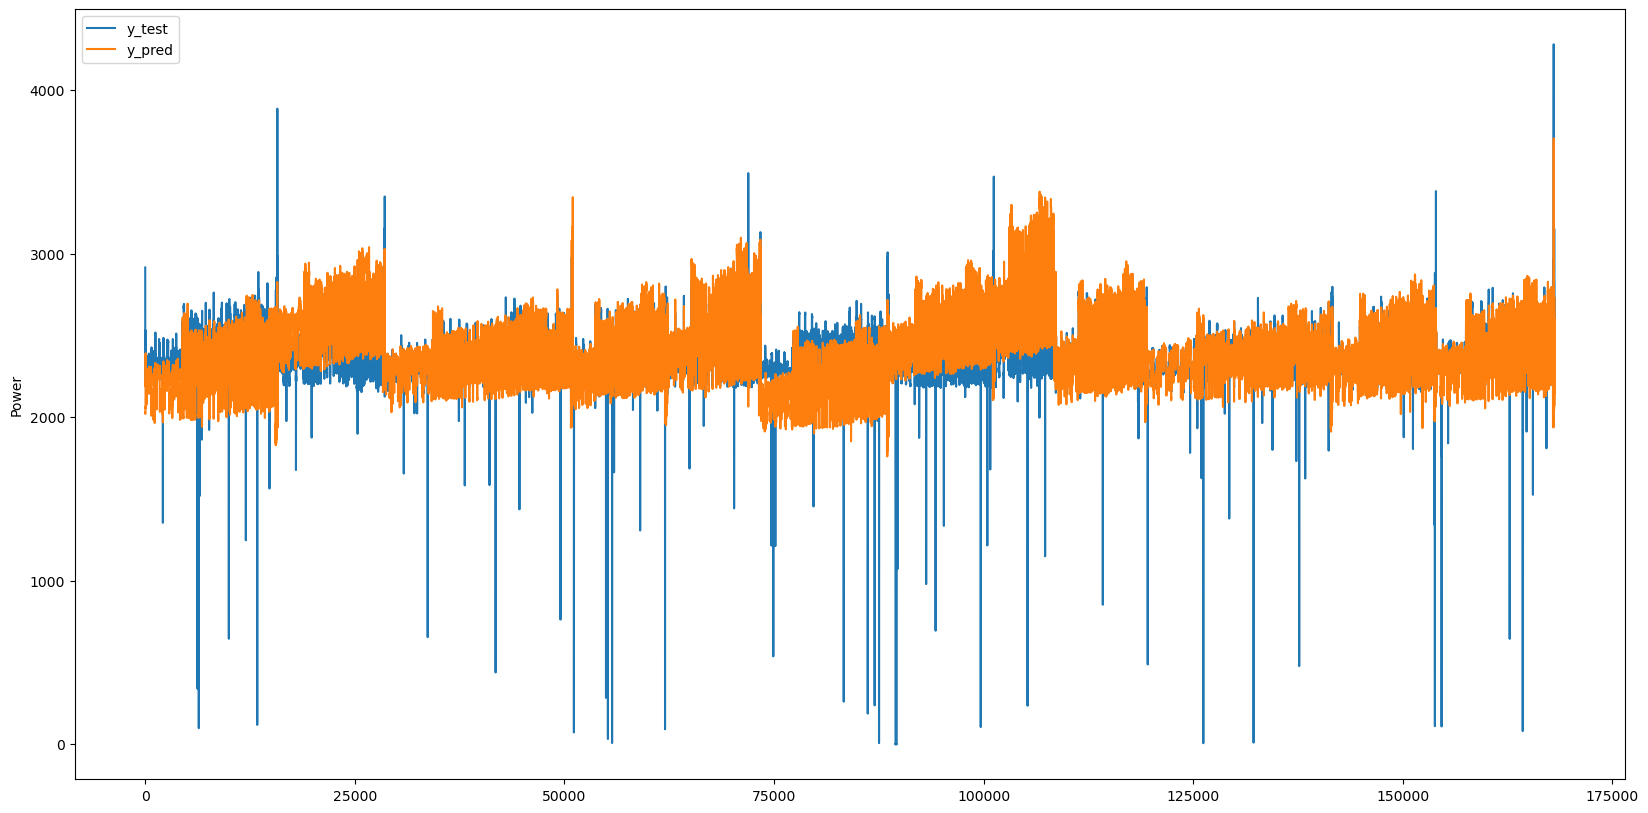

In [18]:
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
print(f"r2: {r2}\nmse: {mse}\nrmse: {rmse}")

plt.figure(figsize=(20, 10))
sns.lineplot(y_test.index, y_test)
sns.lineplot(y_test.index, y_pred)
plt.legend(["y_test", "y_pred"], loc="best")
plt.show()

## without shuffle - include Time

In [19]:
split_idx = int(len(df)*0.7)

x_train = df.drop("Power", axis=1).iloc[:split_idx]
x_test = df.drop("Power", axis=1).iloc[split_idx:]
y_train = df["Power"].iloc[:split_idx]
y_test = df["Power"].iloc[split_idx:]

print(f"feature shape : {x_train.shape}, {x_test.shape}")
print(f"label shape: {y_train.shape}, {y_test.shape}")

feature shape : (117655, 20), (50424, 20)
label shape: (117655,), (50424,)


r2: -4.71214367227695
mse: 111588.91214470741
rmse: 334.04926604425793


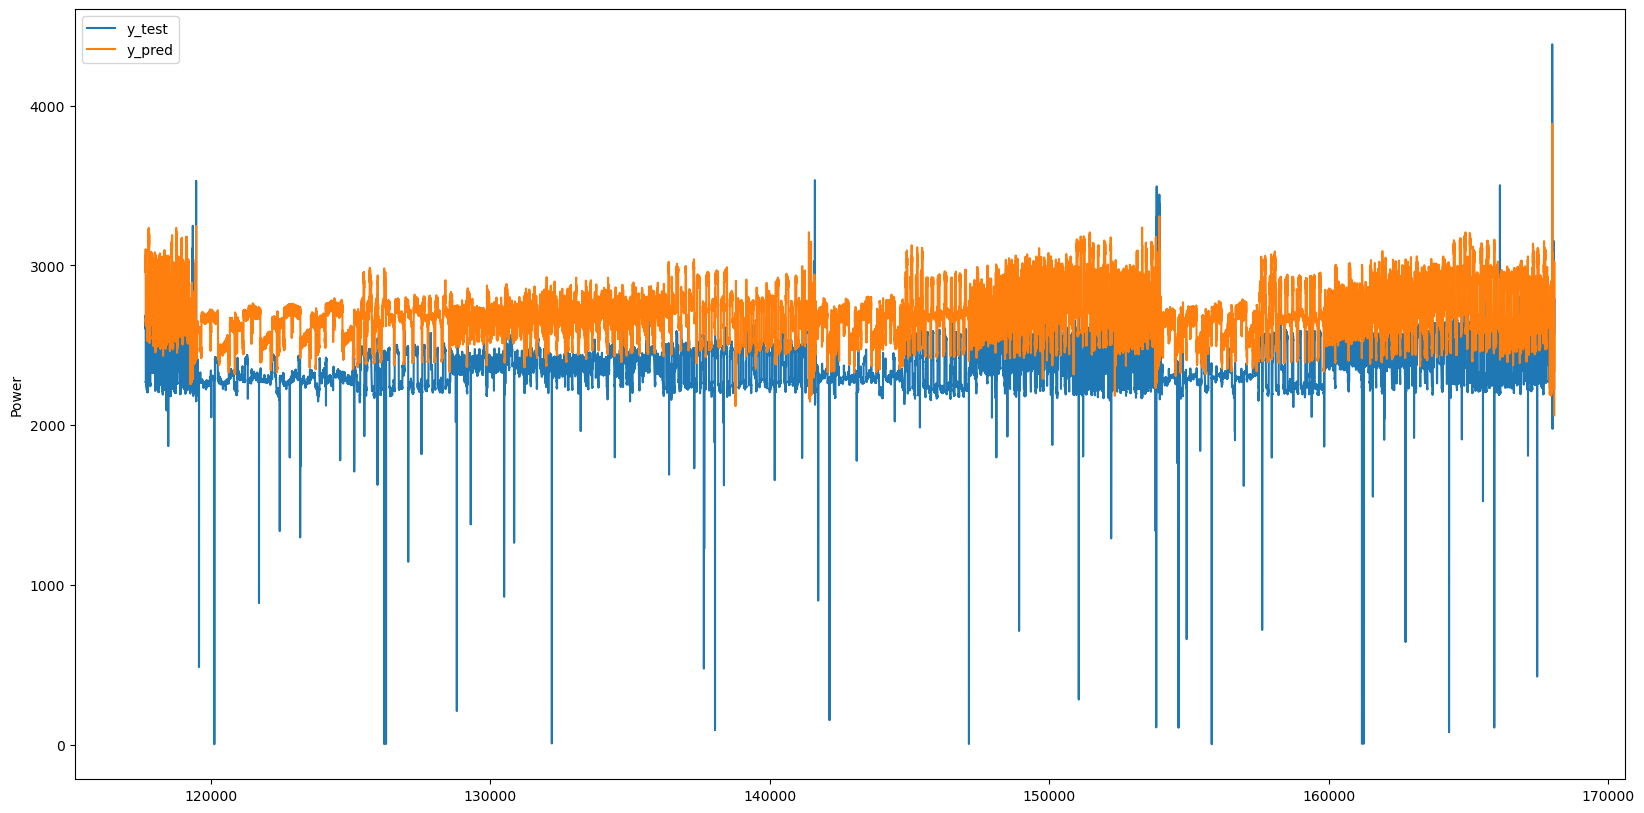

In [20]:
svr = LinearSVR()
svr.fit(x_train, y_train)
y_pred = svr.predict(x_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
print(f"r2: {r2}\nmse: {mse}\nrmse: {rmse}")

plt.figure(figsize=(20, 10))
sns.lineplot(y_test.index, y_test)
sns.lineplot(y_test.index, y_pred)
plt.legend(["y_test", "y_pred"], loc="best")
plt.show()

## Remove Outlier

### Power: 1500 ~ 3000

In [21]:
# Roughly remove outlier
new_df = df[(df["Power"]>1500) & (df["Power"]<3000)]
print(f"new_df.shape: {new_df.shape}\noutlier: {df.shape[0] - new_df.shape[0]}")

new_df.shape: (167554, 21)
outlier: 525


In [22]:
X_train, X_test, y_train, y_test = train_test_split(new_df.drop(["Power"], axis=1),\
                                                    new_df["Power"], test_size=0.33, random_state=42)
print(f"feature shape : {X_train.shape}, {X_test.shape}")
print(f"label shape: {y_train.shape}, {y_test.shape}")

feature shape : (112261, 20), (55293, 20)
label shape: (112261,), (55293,)


In [23]:
svr = LinearSVR()
svr.fit(X_train, y_train)
y_pred = svr.predict(X_test)

r2: 0.10429354996568918
mse: 17797.298201806127
rmse: 133.4065148401911


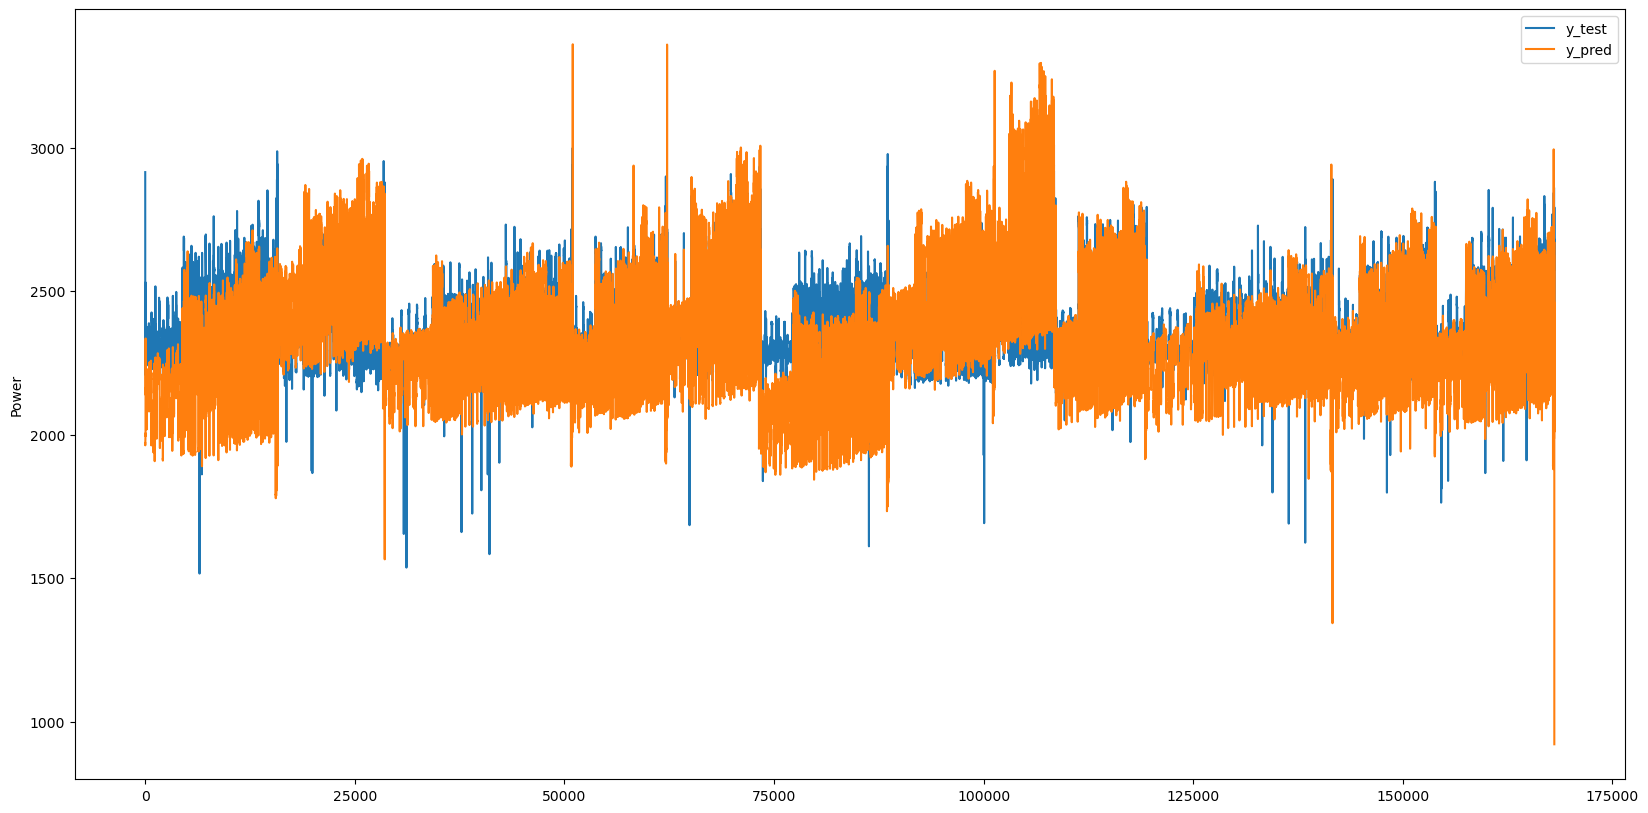

In [24]:
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
print(f"r2: {r2}\nmse: {mse}\nrmse: {rmse}")

plt.figure(figsize=(20, 10))
sns.lineplot(y_test.index, y_test)
sns.lineplot(y_test.index, y_pred)
plt.legend(["y_test", "y_pred"], loc="best")
plt.show()

### Power: 1800 ~ 3000

new_df.shape: (167511, 21)
outlier: 568
feature shape : (112232, 20), (55279, 20)
label shape: (112232,), (55279,)
r2: 0.13971311105789852
mse: 16905.10077120961
rmse: 130.01961687072304


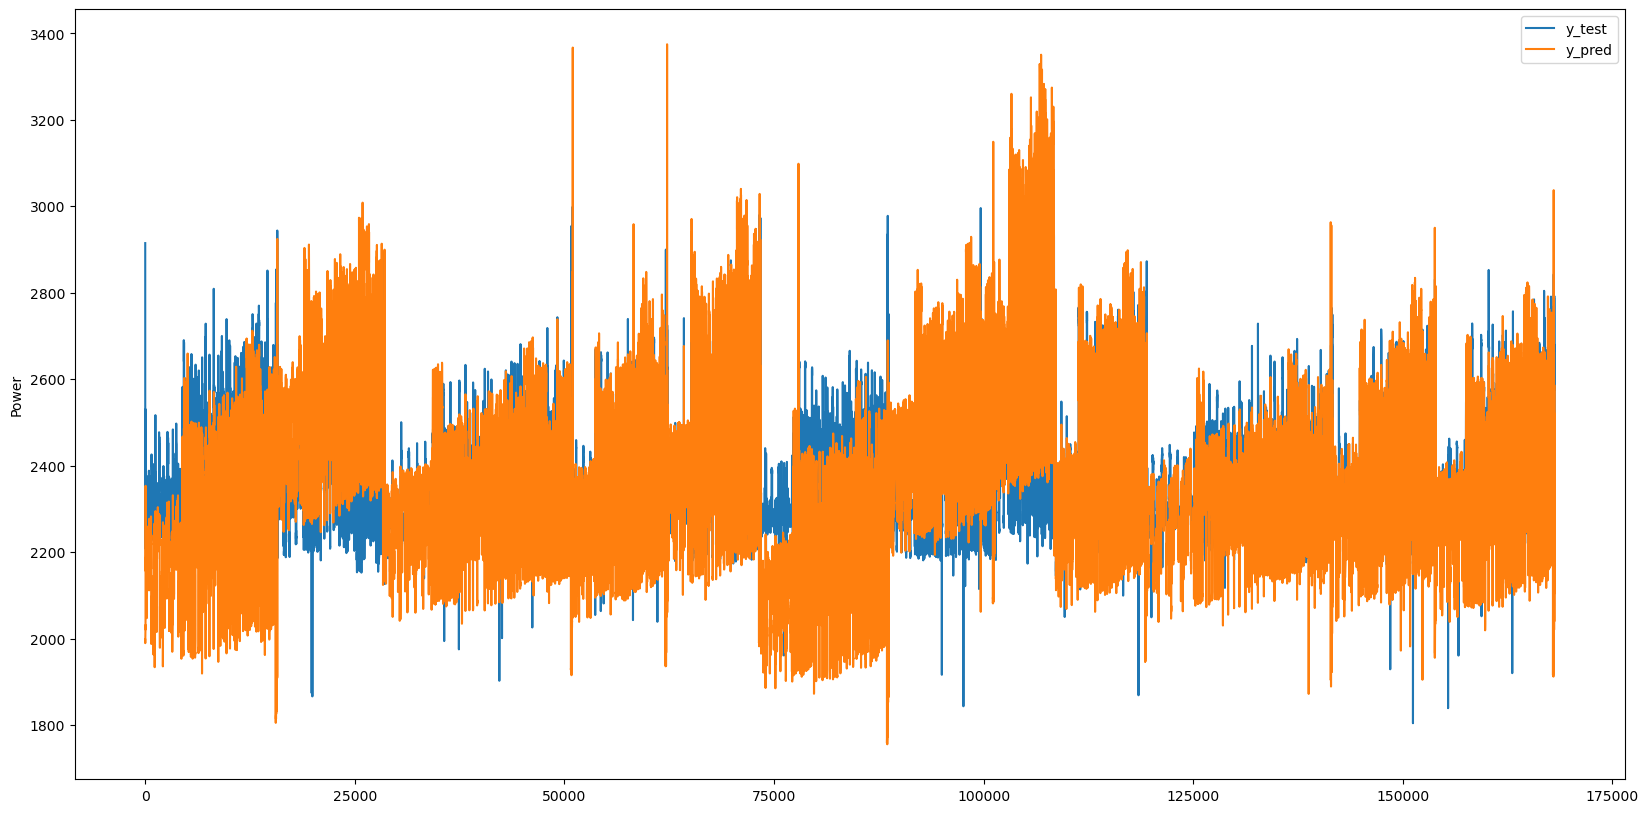

In [25]:
# Roughly remove outlier
new_df = df[(df["Power"]>1800) & (df["Power"]<3000)]
print(f"new_df.shape: {new_df.shape}\noutlier: {df.shape[0] - new_df.shape[0]}")

X_train, X_test, y_train, y_test = train_test_split(new_df.drop(["Power"], axis=1), new_df["Power"], test_size=0.33, random_state=42)
print(f"feature shape : {X_train.shape}, {X_test.shape}")
print(f"label shape: {y_train.shape}, {y_test.shape}")

svr = LinearSVR()
svr.fit(X_train, y_train)
y_pred = svr.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
print(f"r2: {r2}\nmse: {mse}\nrmse: {rmse}")

plt.figure(figsize=(20, 10))
sns.lineplot(y_test.index, y_test)
sns.lineplot(y_test.index, y_pred)
plt.legend(["y_test", "y_pred"], loc="best")
plt.show()